# Clusterização 

Neste exercício, deve-se encontrar padrões nos perfis de carga diários de uma família com o algoritmo de clusterização K-means.

Os dados percorrem o período de dezembro de 2006 até novembro de 2010 e contém 2.075.259 medidas domiciliares coletadas.

Pede-se:
- Identificar perfis de usuários para criar produtos específicos para cada;
- Quantos perfis existem e quais os comportamentos de uso de energia?


### 1 - Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

### 2 - Importando os dados

In [2]:
data_path =  'C:\\Users\\Marcos\\Documents\\datascience_course\\Resumo_Aulas\\dados\\household_power_consumption.txt'
cols_to_use = ['Date', 'Time','Global_active_power']

df = pd.read_csv(data_path, sep=';', usecols=cols_to_use)

In [3]:
df.head()

,Date,Time,Global_active_power
0,16/12/2006,17:24:00,4.216
1,16/12/2006,17:25:00,5.360
2,16/12/2006,17:26:00,5.374
3,16/12/2006,17:27:00,5.388
4,16/12/2006,17:28:00,3.666


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 3 columns):
Date                   object
Time                   object
Global_active_power    object
dtypes: object(3)
memory usage: 47.5+ MB


In [5]:
df.isnull().sum()

Date                   0
Time                   0
Global_active_power    0
dtype: int64

In [6]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'],errors='coerce')

In [7]:
df['Global_active_power'].value_counts(dropna=False)

NaN       25979
 0.218     9565
 0.216     9363
 0.322     9350
 0.324     9304
 0.326     9187
 0.220     9154
 0.320     9113
 0.222     9070
 0.316     9033
 0.318     9026
 0.224     8968
 0.312     8941
 0.314     8840
 0.252     8834
 0.226     8808
 0.328     8714
 0.228     8632
 0.308     8586
 0.310     8538
 0.234     8384
 0.250     8351
 0.306     8349
 0.330     8327
 0.230     8303
 0.232     8254
 0.214     8240
 0.254     8236
 0.236     8002
 0.332     7995
          ...  
 7.606        1
 9.666        1
 9.708        1
 8.036        1
 8.030        1
 8.270        1
 8.302        1
 8.916        1
 9.338        1
 9.922        1
 8.642        1
 8.536        1
 8.264        1
 9.118        1
 9.132        1
 8.246        1
 8.280        1
 8.020        1
 8.084        1
 8.214        1
 9.078        1
 8.174        1
 7.400        1
 7.878        1
 8.504        1
 7.170        1
 8.108        1
 9.374        1
 9.012        1
 8.492        1
Name: Global_active_powe

In [8]:
df['Global_active_power'].fillna(df['Global_active_power'].mean(),inplace=True) 

### 3 - Verificando os dados importados

In [ ]:
!pip install missingno

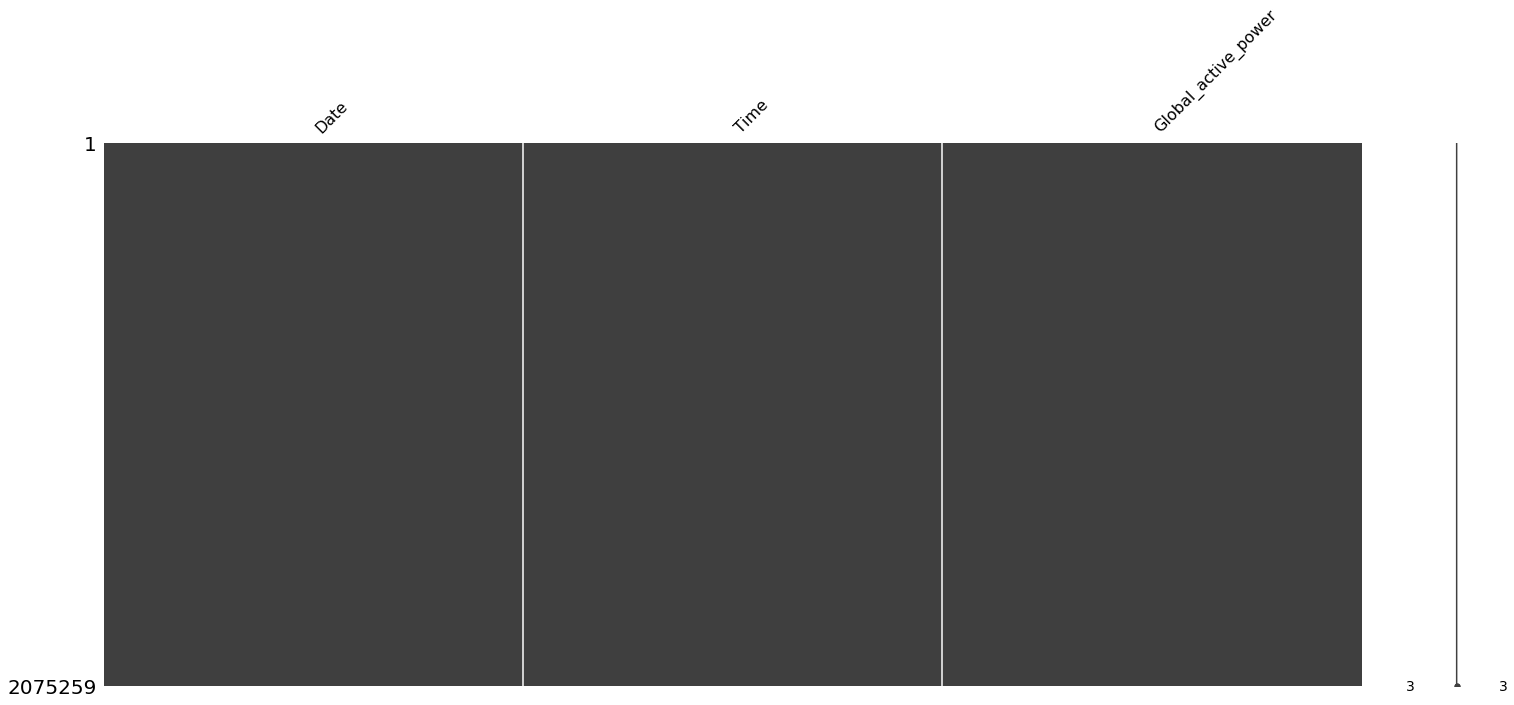

In [11]:
import missingno as msno
msno.matrix(df)

### 4 - Transformando date em datetime

In [14]:
plt.style.use('seaborn')

df['datetime'] = pd.to_datetime(df['Date'] + ' '+ df['Time'])
df = df.drop(['Date','Time'], axis=1)
df = df.set_index('datetime')

In [15]:
df.head()

,Global_active_power
datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [16]:
df.isnull().sum()

Global_active_power    0
dtype: int64

In [17]:
df = df.replace('?', np.nan)
df = df.astype(np.float).fillna(method='bfill')

### 5 - Fazendo um resampling para verificar como é hora-a-hora o consumo de energia

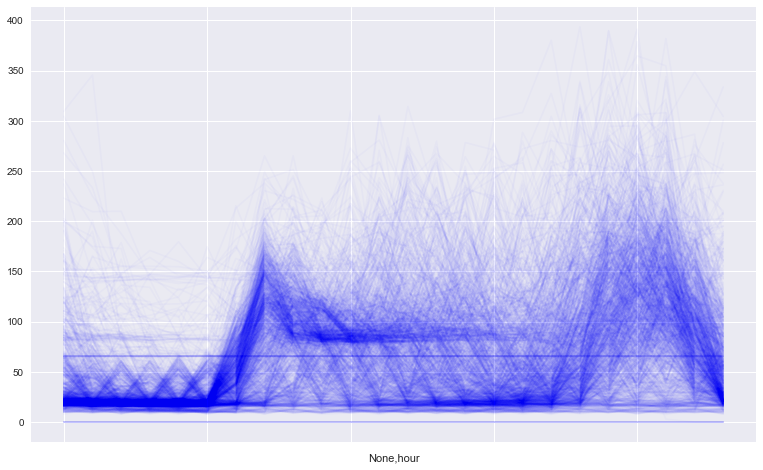

In [18]:
# For simplication,
# I will resample so that each row
# represents a whole hour
df_hourly = df.resample('H').sum()   # obter o consumo por hora
df_hourly['hour'] = df_hourly.index.hour
df_hourly.index = df_hourly.index.date

df_pivot = df_hourly.pivot(columns='hour')
df_pivot = df_pivot.dropna()

df_pivot.T.plot(figsize=(13,8), legend=False, color='blue', alpha=0.02)

### 6 - Aplicando o MinMaxScaler para calcular as distâncias entre os k

K-Means é um algoritmo que calcula distâncias. Para quase todo algoritmo que calcula distâncias, é necessário usar um scaling para padronizar a escala de features. Aplicando o MinMaxScaler :

In [19]:
X = df_pivot.values.copy() #use X

In [20]:
from sklearn.preprocessing import MinMaxScaler
 
# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

### 7 - Método silhouette_score para clusterização

In [21]:
from sklearn.metrics import silhouette_score   ## variância ideal é aquela mais perto de 1, por isso queremos o maior silhouette score

sillhoute_scores = []
n_cluster_list = np.arange(2,31).astype(int)

for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))

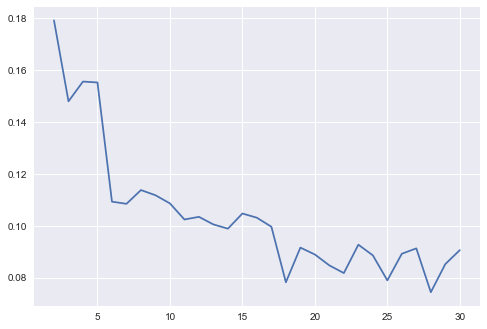

In [22]:
plt.plot(n_cluster_list,sillhoute_scores) # o melhor silhouette score é o 2 - separando em dois clusters (frio e calor)

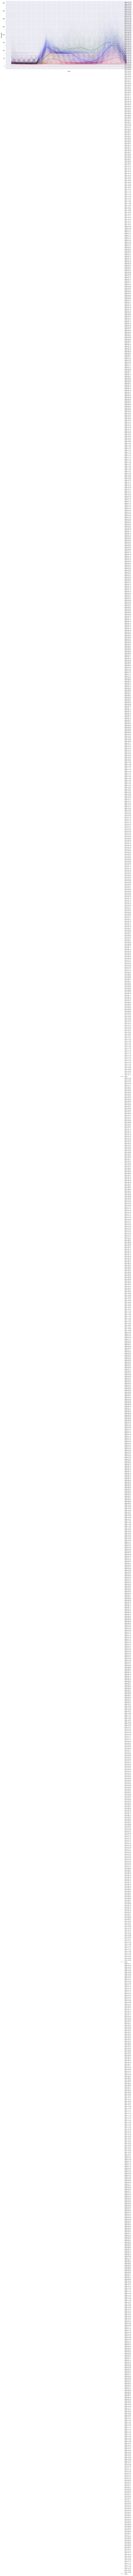

In [24]:
kmeans = KMeans(n_clusters=3)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
df_pivot = df_pivot.set_index(cluster_found_sr, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_pivot.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    df_pivot.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    df_pivot.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )

ax.set_xticks(np.arange(1,25))
ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')
ax.legend()

### 8 - Visualizando os dados

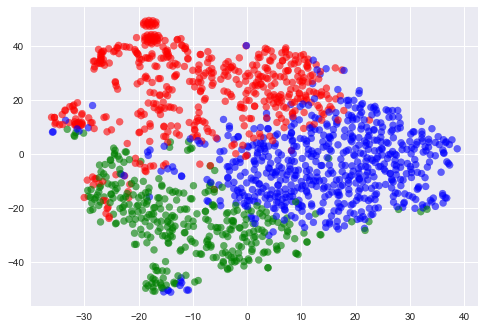

In [26]:
from sklearn.manifold import TSNE
import matplotlib.colors

tsne = TSNE()
results_tsne = tsne.fit_transform(X)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)

plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=df_pivot.index.get_level_values('cluster'),
    cmap=cmap, 
    alpha=0.6, 
    )